This notebook shows how to first train a regression model and then use it to model price elasticity of demand. With this method we can compute partial dependency plots and individual conditional expectation curves.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
import sys
import pickle
import warnings
warnings.filterwarnings('ignore')



This is a second level of imports, using packages built for this context

In [ ]:
additional_code_path = '/Users/briandalessandro/Documents/CrossBoundary/code/rf2019-crossboundary'

sys.path.append(additional_code_path)
from CbModelBuilder.CbModelBuilderUtils import non_model_features, evaluate_regression,evaluate_classification,cap_outlier,train_test_split,plot_confusion_matrix
from CbModelBuilder.FeatureImportanceSummary import FeatureImportanceSummary
from CbModelBuilder.ModelCVWrapper import ModelCVWrapper


Set up data paths

In [ ]:
data_dir_june = '/Users/briandalessandro/Documents/CrossBoundary/E4I-Datasets/June_2019_DataShare/'
modelfile = '/Users/briandalessandro/Documents/CrossBoundary/models/random_forest_regression.pickle'

Read in data

In [2]:
model_df = pd.read_csv(data_dir_june + 'training_all_in.csv')

Load in model (or can regenerate one using the code provided in other files)

In [3]:
with open(modelfile, 'rb') as r:
    reg_model = pickle.load(r)

### Simple Price Elasticity Curve using Partial Dependency Plot

Generate the data to get a population level price-elasticity curve (using the partial dependency plot method)

In [4]:
pdp_df = tariff_pdp(model_df[reg_model.best_subset], reg_model.best_model)

Now plot the curve, along with actual data points

Text(0.5,1,'Tariff vs Expected Consumption')

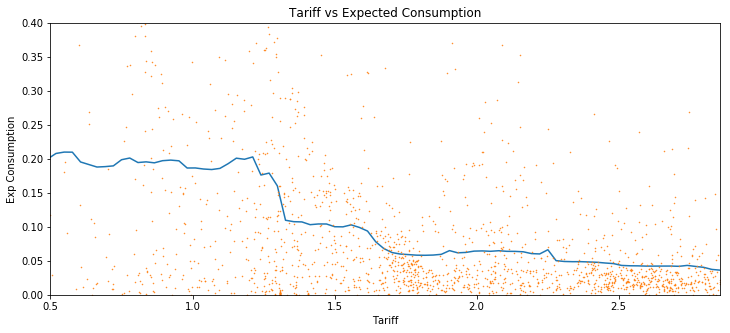

In [5]:
plt.figure(figsize=(12,5))
plt.plot(pdp_df['tariff'],pdp_df['consumption'])
plt.plot(model_df['tariff'], model_df['avg_consumption'],'.', markersize=1)

plt.xlabel('Tariff')
plt.ylabel('Exp Consumption')
plt.xlim([0.5,pdp_df['tariff'].max()])
plt.ylim([0,0.4])
plt.title('Tariff vs Expected Consumption')


## Price Elasticity Curves by Segment

Our goal is to identify and understand segments of the population that may have different price elasticities. We'll define as segment by splitting on individual variables, using a split point like the variables median. In order to find the variables to split, we'll use OLS regression analysis to find which variables have statistically significant interactions (effect modification) with price.

### Identify Segmentation Variables using OLS

First run an OLS regression using a $Y=B*(polynomial expansion price) + B*Variable + B*Price*Variable$. 

We are looking for statistically significant variable and interaction effects

In [6]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

Y = 'avg_consumption'

#These are the varaibles we'll be testing, i.e., all but tariff
intvars = list(set(reg_model.best_subset) - set(['tariff']))


res_list = []

for v in intvars:
    base_df = model_df.copy()
    base_df['X2'] = base_df['tariff']**2 
    base_df['X3'] = base_df['tariff']**3 
    base_df['X4'] = base_df['tariff']**4
    base_df['int'] = base_df.tariff * base_df[v]
    base_df = sm.add_constant(base_df[['tariff','X2','X3','X4',v,'int',Y]])
    
    model = sm.OLS(base_df[Y], base_df[['const','tariff',v, 'int']])
    r = model.fit()
    res_list.append((v,r._results.params[2], r._results.tvalues[2],r._results.params[3],r._results.tvalues[3]))
    

res_df = pd.DataFrame(res_list, columns = ['var','var_coef','var_t','int_coef','int_t'])

#Now choose the variables with significant effects

t_size = 3.25 #This is roughly corresponding to a 5% p-value after adjusting for multiple comparisons using Bonferroni correction

sig_res_df = res_df[(np.abs(res_df.var_t)>t_size) & (np.abs(res_df.int_t)>t_size)].copy()
sig_res_df['tot'] = np.abs(sig_res_df.var_t) + np.abs(sig_res_df.int_t)
sig_res_df = sig_res_df.sort_values(by='tot',ascending=False)
sig_res_df

,var,var_coef,var_t,int_coef,int_t,tot
7,non_self_generated_electricity_monthly_consump...,0.023066,9.927073,-0.012175,-9.926010,19.853083
27,uses_of_non_self_generated_electricity_has_fan,0.388852,10.207114,-0.150180,-7.786759,17.993872
15,cooking_tech,0.077116,7.175764,-0.032572,-5.778820,12.954585
18,years_in_community,-0.006762,-6.900354,0.002827,5.803718,12.704072
8,perfect_life,0.133541,6.468201,-0.052710,-5.216644,11.684845
12,achieved_important_things_i_want,0.102128,5.486368,-0.043527,-4.906854,10.393222
14,non_self_generated_electricity_unit_price_per_kw,-0.000034,-4.737456,0.000022,5.291309,10.028765
23,phone_charger_type_of_use,0.485958,5.362049,-0.192015,-4.157962,9.520011
19,credit_recharge_average,0.000058,4.667561,-0.000023,-4.245514,8.913074
13,phone,0.011762,4.001384,-0.005813,-3.404106,7.405491


For each of the variables identified above, we'll generate a PDP elasticity curve splitting on each

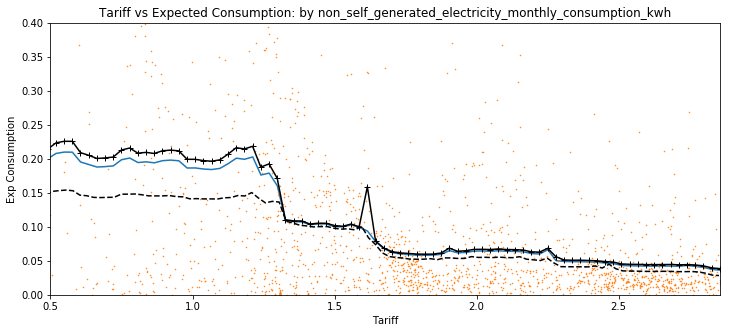

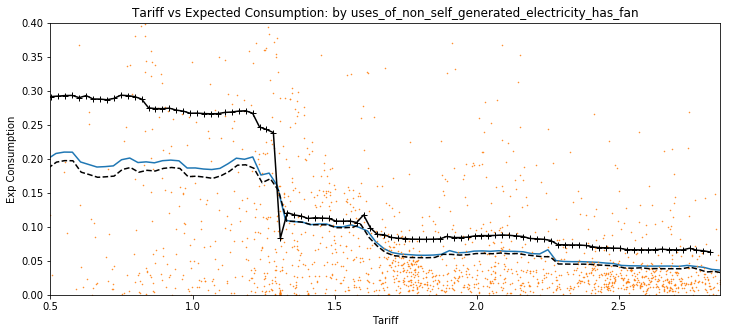

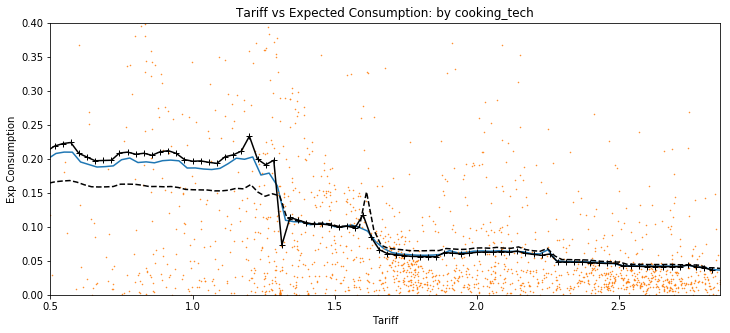

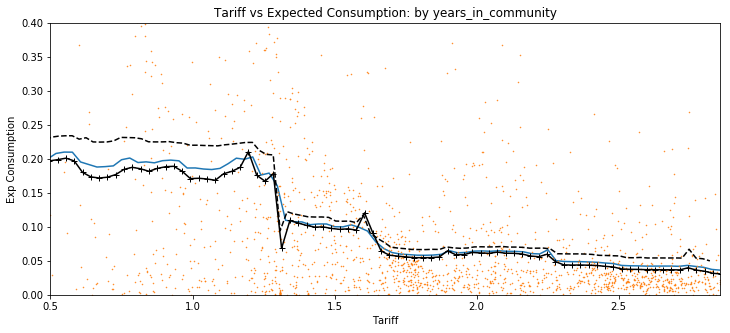

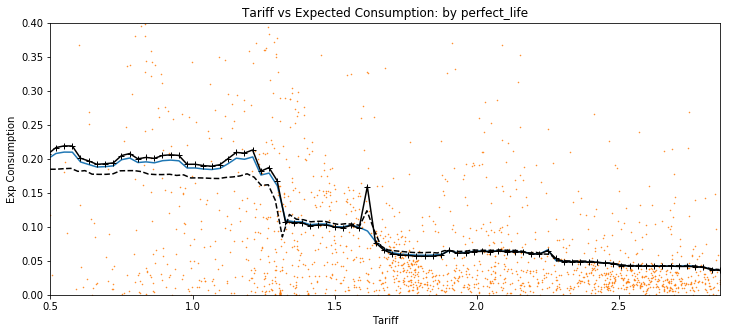

In [7]:
split_vars = sig_res_df['var'].values

for var in split_vars[0:5]:
    
    #If the variable is binary, split on the 0/1, else use the median
    if model_df[var].value_counts().shape[0] == 2:
        split_value = 1
    else:
        split_value = model_df[var].median()
        
    seg_pdp_df = segmented_pdp(model_df[reg_model.best_subset], reg_model.best_model, var, split_value)

    
    #Note the plotting here assumes you've build the population level version
    plt.figure(figsize=(12,5))
    plt.plot(pdp_df['tariff'],pdp_df['consumption'])
    plt.plot(model_df['tariff'], model_df['avg_consumption'],'.', markersize=1)
    f0 = (seg_pdp_df['split']==0)
    f1 = (seg_pdp_df['split']==1)    
    plt.plot(seg_pdp_df['tariff'][f0], seg_pdp_df['consumption'][f0], 'k--')
    plt.plot(seg_pdp_df['tariff'][f1], seg_pdp_df['consumption'][f1], 'k-+')

    
    plt.xlabel('Tariff')
    plt.ylabel('Exp Consumption')
    plt.xlim([0.5,pdp_df['tariff'].max()])
    plt.ylim([0,0.4])
    plt.title('Tariff vs Expected Consumption: by {}'.format(var))

The idea here is to use the above to visually validate whether the elasticity curves have meaningful differences when you segment the population by the give variable. 

## Segmentation by Individual Conditional Expectation Curves

An ICE is like a PDP, but it is calculated for each individual. One potential application of our regression model is to compute each individual's expected consumption at different price points, and then cluster the individuals based on having similar price sensitivities. We can use the regression model, ICE curves and a clustering algorithm to do this.

First get expected consumption for each person at a few well spaced price points

In [8]:
tariff_quantiles = np.percentile(model_df['tariff'], [10,25,50,75,90])

preds = []
for i, tar in enumerate(tariff_quantiles):
    pd_test = model_df.copy()    
    pd_test['tariff'] = tar
    
    preds.append(reg_model.best_model.predict(pd_test[reg_model.best_subset]))
    
    
for i in range(len(preds)):
    pd_test['pred_{}'.format(i)] = preds[i]

Now cluster the individuals based on the predicted consumption at each price point. Note, there is no one best way to approach clustering. I.e., there is not magic number of clusters one can identify a-priori. Below is an example, but general clustering best practices apply.

In [9]:
from sklearn.cluster import KMeans

cvars = ['pred_{}'.format(i) for i in range(len(preds))]

kmeans = KMeans(n_clusters=6, random_state=0).fit(pd_test[cvars])

Now we can plot the clusters to get a better interpretation of them. 

Text(0.5,1,'Price vs Expected Consumption by Cluster')

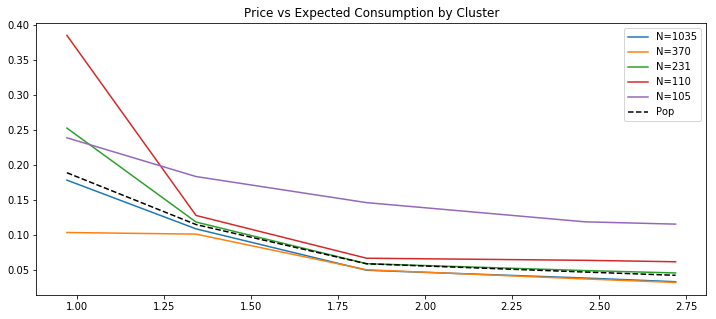

In [10]:
plt.figure(figsize=(12,5))
ccnt = pd.Series(kmeans.predict(pd_test[cvars])).value_counts()

for i in ccnt.index.values:
    if ccnt.loc[i]>20:
        plt.plot(tariff_quantiles, kmeans.cluster_centers_[i], label='N={}'.format(ccnt.loc[i]))
        
#Get population average and plot for reference
plt.plot(tariff_quantiles, pd_test[cvars].mean(), 'k--', label='Pop')

plt.legend()
plt.title('Price vs Expected Consumption by Cluster')

Looking at the above plot, we can see the clustering does draw out differences in behavior. We have one group that has overall higher consumption, even though their elasticity (the slope) is low. Likewise, another has low elasticity but the consumption line is shifted down. One group has very high elasticity (high slope).